# RNN Models

## Import Libraries

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Embedding, Flatten, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)


## Model Variables

In [41]:
features = ['Open', 'High', 'Low', 'Volume']
target   = 'target'
rolling_window = 10 

## Data Pre-Processing

In [42]:
df = pd.read_csv("../filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date', 'ticker']).reset_index(drop=True)

df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target']     = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close']).reset_index(drop=True)

## Dataset Split

In [43]:
# 2. Static 60/20/20 split
n_total  = len(df)
n_train  = int(0.6 * n_total)
n_val    = int(0.2 * n_total)

train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:n_train+n_val]
test_df  = df.iloc[n_train+n_val:].reset_index(drop=True)

## Feature Extraction & Scaling

In [44]:
scaler       = StandardScaler().fit(train_df[features])
X_train_s    = scaler.transform(train_df[features])
X_val_s      = scaler.transform(val_df[features])
y_train_arr  = train_df['target'].values
y_val_arr    = val_df['target'].values

## Create RNN Sequences

In [45]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_arr, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_s,   y_val_arr,   rolling_window)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq:", X_val_seq.shape,   y_val_seq.shape)

Train seq: (45260, 10, 4) (45260,)
Val   seq: (15080, 10, 4) (15080,)


## Base RNN Model
With untuned test parameters to check if model is working.

In [46]:
n_features = X_train_seq.shape[2]
model = Sequential([
    SimpleRNN(64, input_shape=(rolling_window, n_features)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'],
)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1415/1415 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5031 - loss: 0.7068 - val_accuracy: 0.5124 - val_loss: 0.6935
Epoch 2/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5147 - loss: 0.6946 - val_accuracy: 0.5077 - val_loss: 0.6933
Epoch 3/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5077 - loss: 0.6941 - val_accuracy: 0.5132 - val_loss: 0.6936
Epoch 4/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5119 - loss: 0.6935 - val_accuracy: 0.5143 - val_loss: 0.6928
Epoch 5/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5147 - loss: 0.6930 - val_accuracy: 0.5137 - val_loss: 0.6932
Epoch 6/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5082 - loss: 0.6932 - val_accuracy: 0.5129 - val_loss: 0.6926
Epoch 7/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5164 - loss: 0.6926 - val_accuracy: 0.5144 - val_loss: 0.6931
Epoch 8/10
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5163 - loss: 0.6927 - val_accurac

### Running RNN on test data
RNN Model is run on rolling window test set from each year.

In [47]:
test_df['Year']     = test_df['Date'].dt.year
unique_years       = sorted(test_df['Year'].unique())
all_y_true, all_y_pred, all_y_proba = [], [], []
all_test_dates = []

for year in unique_years:
    year_test = test_df[test_df['Year']==year].reset_index(drop=True)
    Xt_s, yt_arr = (
        scaler.transform(year_test[features]),
        year_test['target'].values
    )
    Xt_seq, yt_seq = create_sequences(Xt_s, yt_arr, rolling_window)
    if Xt_seq.size == 0:
        continue

    proba = model.predict(Xt_seq).ravel()
    pred  = (proba > 0.5).astype(int)

    all_y_true.extend(yt_seq.tolist())
    all_y_pred.extend(pred.tolist())
    all_y_proba.extend(proba.tolist())
    all_test_dates.extend(year_test['Date'].iloc[rolling_window:].tolist())

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


### Evaluation


Rolling‑Window RNN Results:
Accuracy: 0.5206
F1 Score:  0.6421
AUC‑ROC:   0.5136

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            1366          5912
Actual Up              1312          6480


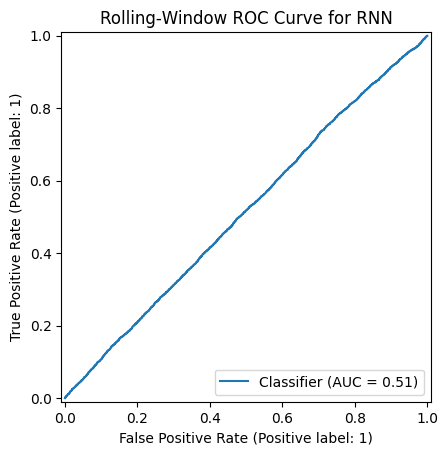

In [48]:
accuracy = accuracy_score(all_y_true, all_y_pred)
f1       = f1_score(all_y_true, all_y_pred)
auc      = roc_auc_score(all_y_true, all_y_proba)
cm       = confusion_matrix(all_y_true, all_y_pred)

print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for RNN')
plt.show()

## Best RNN Model
Single layer basic RNN, with optimal parameters determined by a random search autotuner.

In [49]:
def build_rnn_model(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            input_shape=(rolling_window, len(features))
        ),
        Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class BacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_model(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            year_test = test_df[test_df['Year']==year]
            if idx == 0:
                year_train = train_df
            else:
                cutoff = year_test['Date'].min()
                up_to = df[df['Date'] < cutoff]
                size = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if X_tr_seq.size == 0 or X_te_seq.size == 0:
                continue

            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )

            y_pred = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, y_pred))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = BacktestTuner(
    hypermodel=build_rnn_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    directory='rnn_backtest_tuner',
    project_name='rb_tuner'
)

tuner.search() 

Reloading Tuner from rnn_backtest_tuner\rb_tuner\tuner0.json


### Evaluation

In [50]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_rnn_model(best_hp)

X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,            
    batch_size=32,
    verbose=1
)

y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4962 - loss: 0.7119
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5060 - loss: 0.7059
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5044 - loss: 0.7054
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5005 - loss: 0.7067
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4957 - loss: 0.7067
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5051 - loss: 0.7072
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5039 - loss: 0.7061
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5030 - loss: 0.7069
Epoch 9/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5053 - loss: 0.7068
Epoch 10/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5078 - loss: 0.7031
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [51]:
print(best_hp.values)

{'units': 64, 'dropout': 0.2, 'lr': 0.01}



Rolling‑Window RNN Results:
Accuracy: 0.4987
F1 Score:  0.5015
AUC‑ROC:   0.4999

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            3104          2907
Actual Up              3404          3175


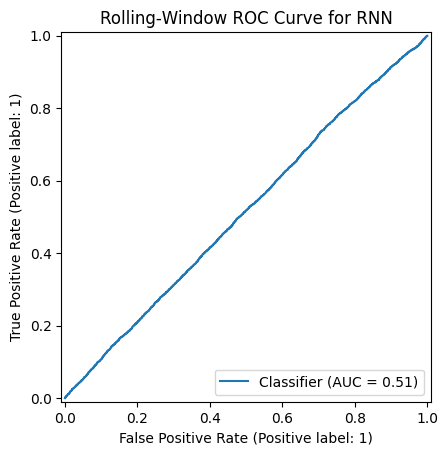

In [52]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for RNN')
plt.show()

## Deeper RNN
Experiment with stacking more RNN layers (varied from 2-4). More recurrent layers can potentially better learn the temporal dependencies between the input features.

In [53]:
def build_deep_rnn(hp):
    model = Sequential()
    n_layers = hp.Int('n_layers', 2, 4)
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', 32, 256, step=32)
        return_seq = (i < n_layers-1)
        if i == 0:
            model.add(SimpleRNN(units,
                                return_sequences=return_seq,
                                input_shape=(rolling_window, len(features))))
        else:
            model.add(SimpleRNN(units, return_sequences=return_seq))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class DeepBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_deep_rnn(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            if idx == 0:
                year_train = train_df
            else:
                cutoff = test_df[test_df['Year']==year]['Date'].min()
                up_to  = df[df['Date'] < cutoff]
                size   = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            year_test = test_df[test_df['Year']==year]
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )

            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = DeepBacktestTuner(
    hypermodel=build_deep_rnn,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=10,
    directory='rnn_backtest_tuner',
    project_name='deep_rnn_search'
)
tuner.search()


Trial 10 Complete [00h 01m 34s]
val_accuracy: 0.49975531015398805

Best val_accuracy So Far: 0.519697692741295
Total elapsed time: 00h 14m 14s


### Evaluation
Get best model from tuner & retrain that model.

In [54]:
best_hp    = tuner.get_best_hyperparameters(1)[0]
print("Best config:")
print(f"  layers    = {best_hp.get('n_layers')}")
for i in range(best_hp.get('n_layers')):
    print(f"    units_{i}   = {best_hp.get(f'units_{i}')}")
    print(f"    dropout_{i} = {best_hp.get(f'dropout_{i}')}")
print(f"  learning_rate = {best_hp.get('lr')}")
best_model = build_deep_rnn(best_hp)

X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,              
    batch_size=32,
    verbose=1
)

y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

Best config:
  layers    = 3
    units_0   = 64
    dropout_0 = 0.0
    units_1   = 224
    dropout_1 = 0.2
    units_2   = 192
    dropout_2 = 0.2
  learning_rate = 0.01
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5035 - loss: 0.7439
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5022 - loss: 0.7260
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5043 - loss: 0.7287
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5043 - loss: 0.7247
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5008 - loss: 0.7309
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5003 - loss: 0.7423
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4983 - loss: 0.7243
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5049 - loss: 0.7236
Epoch 9/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4985 - loss: 0.7341
Epoch 10/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5040 - loss: 0.7242
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step



Rolling‑Window RNN Results:
Accuracy: 0.4809
F1 Score:  0.1982
AUC‑ROC:   0.4973

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5246           765
Actual Up              5771           808


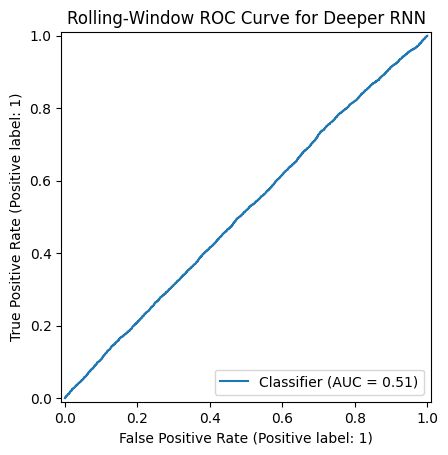

In [55]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for Deeper RNN')
plt.show()

## RNN with more Dense Layers
Attempt to add more dense layers to learn/represent more complex decision boundaries over teh vector space before we output the final classification.

In [56]:
def build_rnn_with_dense(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', 32, 256, step=32),
        input_shape=(rolling_window, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rnn', 0.0, 0.5, step=0.1)))
    n_dense = hp.Int('n_dense', 1, 3)
    for i in range(n_dense):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', 16, 128, step=16),
            activation=hp.Choice(f'dense_act_{i}', ['relu','tanh'])
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{i}', 0.0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

class DenseBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_with_dense(hp)
        accs = []

        for idx, year in enumerate(unique_years):
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values
            year_test = test_df[test_df['Year']==year]
            X_te_s    = scaler.transform(year_test[features])
            y_te      = year_test['target'].values

            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            model.fit(X_tr_seq, y_tr_seq, epochs=5, batch_size=32, verbose=1)
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(accs) if accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

tuner = DenseBacktestTuner(
    hypermodel=build_rnn_with_dense,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=12,
    directory='dense_backtest_tuner',
    project_name='rnn_dense_search'
)
tuner.search()

Trial 12 Complete [00h 00m 33s]
val_accuracy: 0.49564074149991033

Best val_accuracy So Far: 0.5167223410797099
Total elapsed time: 00h 06m 22s


### Evaluation

In [57]:
best_hp    = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)
best_model = build_rnn_with_dense(best_hp)

X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,              
    batch_size=32,
    verbose=1
)

y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

{'rnn_units': 160, 'dropout_rnn': 0.1, 'n_dense': 2, 'dense_units_0': 112, 'dense_act_0': 'tanh', 'dropout_dense_0': 0.4, 'lr': 0.01, 'dense_units_1': 48, 'dense_act_1': 'relu', 'dropout_dense_1': 0.1, 'dense_units_2': 80, 'dense_act_2': 'relu', 'dropout_dense_2': 0.2}
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5060 - loss: 0.7148
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5029 - loss: 0.6998
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5104 - loss: 0.7012
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5064 - loss: 0.6992
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5060 - loss: 0.6975
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5058 - loss: 0.6992
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5131 - loss: 0.6935
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5158 - loss: 0.6939
Epoch 9/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5105 - loss: 0.7069
Epoch 10/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5140 - loss: 0.6937
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



Rolling‑Window RNN Results:
Accuracy: 0.5221
F1 Score:  0.6856
AUC‑ROC:   0.4985

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down              11          6000
Actual Up                17          6562


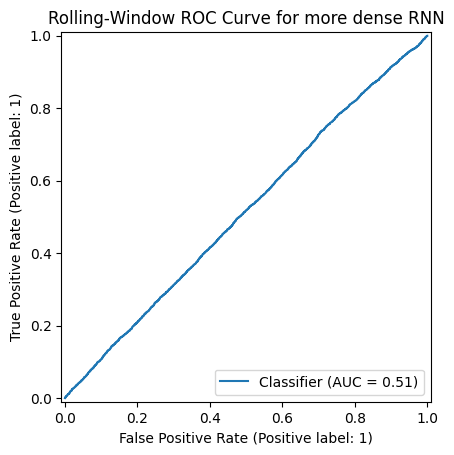

In [58]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print("\nRolling‑Window RNN Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('Rolling‑Window ROC Curve for more dense RNN')
plt.show()

## RNN with Normalization
Normalizes all elements in hidden-state vectors across its features before activation function. Helps prevents neurons from drifting too far into the extremes of the activation function, helping to reduce vanishing/exploding gradient issues.

In [59]:
def build_rnn_with_norm(hp):
    model = Sequential()
    # -- single RNN layer --
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', 32, 256, step=32),
        input_shape=(rolling_window, len(features))
    ))
    model.add(Dropout(hp.Float('dropout_rnn', 0.0, 0.5, step=0.1)))
    model.add(LayerNormalization())

    # -- tunable dense layers on top --
    n_dense = hp.Int('n_dense', 1, 3)
    for i in range(n_dense):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', 16, 128, step=16),
            activation=hp.Choice(f'dense_act_{i}', ['relu','tanh'])
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{i}', 0.0, 0.5, step=0.1)))

    # -- output layer --
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ── 2) Custom backtest tuner ──
class NormBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = build_rnn_with_norm(hp)
        year_accs = []

        for idx, year in enumerate(unique_years):
            # select train slice
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            # scale
            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values

            year_test = test_df[test_df['Year']==year]
            X_te_s = scaler.transform(year_test[features])
            y_te   = year_test['target'].values

            # sequences
            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if len(X_tr_seq)==0 or len(X_te_seq)==0:
                continue

            # train quietly
            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=10, batch_size=32,
                verbose=1
            )

            # evaluate this year
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            year_accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(year_accs) if year_accs else 0.0
        # report mean accuracy over years
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# ── 3) Run the tuner ──
tuner = NormBacktestTuner(
    hypermodel=build_rnn_with_norm,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=12,
    directory='norm_backtest_tuner',
    project_name='rnn_norm_search'
)
tuner.search()

Trial 12 Complete [00h 01m 28s]
val_accuracy: 0.5068066373722104

Best val_accuracy So Far: 0.5167223410797099
Total elapsed time: 00h 17m 31s


### Evaluation

In [60]:
best_hp    = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)
best_model = build_rnn_with_norm(best_hp)

X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,              
    batch_size=32,
    verbose=1
)

y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

{'rnn_units': 256, 'dropout_rnn': 0.1, 'n_dense': 2, 'dense_units_0': 112, 'dense_act_0': 'relu', 'dropout_dense_0': 0.1, 'lr': 0.01, 'dense_units_1': 48, 'dense_act_1': 'relu', 'dropout_dense_1': 0.4}
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5159 - loss: 0.7063
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5143 - loss: 0.6930
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5147 - loss: 0.6928
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5136 - loss: 0.6929
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5154 - loss: 0.6928
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5145 - loss: 0.6928
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5153 - loss: 0.6930
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5146 - loss: 0.6929
Epoch 9/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5126 - loss: 0.6929
Epoch 10/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5153 - loss: 0.6928
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy: 0.5226
F1 Score:  0.6864
AUC‑ROC:   0.5000

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down               0          6011
Actual Up                 0          6579


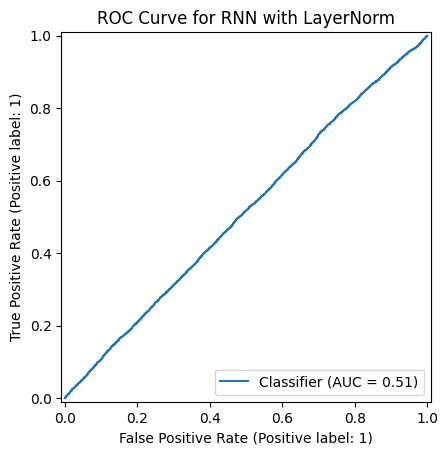

In [61]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('ROC Curve for RNN with LayerNorm')
plt.show()

## RNN with gradient clipping
Attempt to deal with exploding gradients during backpropagation (if any). Improves stability when training with larger learning rates.

In [62]:
def build_clip_rnn(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('units', 32, 256, step=32),
            input_shape=(rolling_window, len(features))
        ),
        Dense(1, activation='sigmoid'),
    ])
    lr = hp.Choice('lr', [5e-1, 1e-1, 1e-2, 1e-3, 1e-4])
    clipnorm = hp.Float('clipnorm', 0.0, 2.0, step=0.5)
    if clipnorm > 0:
        optimizer = Adam(learning_rate=lr, clipnorm=clipnorm)
    else:
        optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ── 4) Custom backtest tuner (per‑year rolling backtest) ──
class ClipBacktestTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp    = trial.hyperparameters
        model = build_clip_rnn(hp)
        accs  = []

        for idx, year in enumerate(unique_years):
            # build year_train
            if idx == 0:
                year_train = train_df
            else:
                cutoff     = test_df[test_df['Year']==year]['Date'].min()
                up_to      = df[df['Date'] < cutoff]
                size       = int(0.6 * len(up_to))
                year_train = up_to.iloc[:size]

            # scale features
            scaler = StandardScaler().fit(year_train[features])
            X_tr_s = scaler.transform(year_train[features])
            y_tr   = year_train['target'].values

            year_test = test_df[test_df['Year']==year]
            X_te_s    = scaler.transform(year_test[features])
            y_te      = year_test['target'].values

            # create sequences
            X_tr_seq, y_tr_seq = create_sequences(X_tr_s, y_tr, rolling_window)
            X_te_seq, y_te_seq = create_sequences(X_te_s, y_te, rolling_window)
            if not len(X_tr_seq) or not len(X_te_seq):
                continue

            # train & evaluate quietly
            model.fit(
                X_tr_seq, y_tr_seq,
                epochs=5, batch_size=32,
                verbose=1
            )
            preds = (model.predict(X_te_seq).ravel() > 0.5).astype(int)
            accs.append(accuracy_score(y_te_seq, preds))

        mean_acc = np.mean(accs) if accs else 0.0
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': mean_acc})

# ── 5) Run the tuner ──
tuner = ClipBacktestTuner(
    hypermodel=build_clip_rnn,
    objective=kt.Objective('val_accuracy','max'),
    max_trials=10,
    directory='clip_rnn_tuner',
    project_name='clip_backtest'
)
tuner.search()

Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.5058352443055164

Best val_accuracy So Far: 0.5163191152732584
Total elapsed time: 00h 04m 17s


### Evaluation

In [63]:
best_hp    = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)
best_model = build_clip_rnn(best_hp)

X_combined_seq = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_combined_seq = np.concatenate([y_train_seq, y_val_seq], axis=0)

best_model.fit(
    X_combined_seq, y_combined_seq,
    epochs=10,              
    batch_size=32,
    verbose=1
)

y_proba_test = best_model.predict(Xt_seq).ravel()
y_pred_test  = (y_proba_test > 0.5).astype(int)

{'units': 96, 'lr': 0.1, 'clipnorm': 1.0}
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1886/1886 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5053 - loss: 0.8839
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4991 - loss: 0.9432
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5019 - loss: 0.9176
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4957 - loss: 0.9088
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5033 - loss: 0.9053
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5047 - loss: 0.8928
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4953 - loss: 0.9701
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5013 - loss: 0.8569
Epoch 9/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4993 - loss: 0.9113
Epoch 10/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5058 - loss: 0.8841
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


Accuracy: 0.4781
F1 Score:  0.0341
AUC‑ROC:   0.5004

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5903           108
Actual Up              6463           116


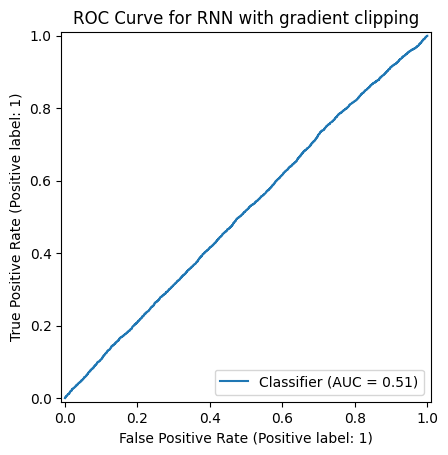

In [64]:
accuracy = accuracy_score(yt_seq, y_pred_test)
f1  = f1_score(yt_seq, y_pred_test)
auc = roc_auc_score(yt_seq, y_proba_test)
cm  = confusion_matrix(yt_seq, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC‑ROC:   {auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=['Actual Down','Actual Up'],
    columns=['Predicted Down','Predicted Up']
))

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('ROC Curve for RNN with gradient clipping')
plt.show()